In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time
import scipy.io

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

## Load data

In [2]:
v98 = ulmo_io.load_main_table('s3://viirs/Tables/VIIRS_all_98clear_std.parquet')
llc = ulmo_io.load_main_table('s3://llc/Tables/llc_viirs_match.parquet')

Read main table: s3://viirs/Tables/VIIRS_all_98clear_std.parquet
Read main table: s3://llc/Tables/llc_viirs_match.parquet


## Set up Figure inputs

In [3]:
tmin=True
tmax=True
title=True

## Divvy viirs & llc cutouts into LL deciles

In [4]:
# divvy up cutouts into percentiles
l10, l20, l30, l40, l50, l60, l70, l80, l90, l100 = np.percentile(llc.dropna( subset='LL').LL.to_numpy(), [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
v10, v20, v30, v40, v50, v60, v70, v80, v90, v100 = np.percentile(v98.LL.to_numpy(), [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

lr10  = llc[ (llc.LL < l10 ) ]
lr20  = llc[ (llc.LL > l10 ) & (llc.LL < l20) ]
lr30  = llc[ (llc.LL > l20 ) & (llc.LL < l30) ]
lr40  = llc[ (llc.LL > l30 ) & (llc.LL < l40) ]
lr50  = llc[ (llc.LL > l40 ) & (llc.LL < l50) ]
lr60  = llc[ (llc.LL > l50 ) & (llc.LL < l60) ]
lr70  = llc[ (llc.LL > l60 ) & (llc.LL < l70) ]
lr80  = llc[ (llc.LL > l70 ) & (llc.LL < l80) ]
lr90  = llc[ (llc.LL > l80 ) & (llc.LL < l90) ]
lr100 = llc[ (llc.LL > l90 ) & (llc.LL < l100) ]

llc_rs = [lr10, lr20, lr30, lr40, lr50, lr60, lr70, lr80, lr90, lr100]

vr10  = v98[ (v98.LL < v10 ) ]
vr20  = v98[ (v98.LL > v10 ) & (v98.LL < v20) ]
vr30  = v98[ (v98.LL > v20 ) & (v98.LL < v30) ]
vr40  = v98[ (v98.LL > v30 ) & (v98.LL < v40) ]
vr50  = v98[ (v98.LL > v40 ) & (v98.LL < v50) ]
vr60  = v98[ (v98.LL > v50 ) & (v98.LL < v60) ]
vr70  = v98[ (v98.LL > v60 ) & (v98.LL < v70) ]
vr80  = v98[ (v98.LL > v70 ) & (v98.LL < v80) ]
vr90  = v98[ (v98.LL > v80 ) & (v98.LL < v90) ]
vr100 = v98[ (v98.LL > v90 ) & (v98.LL < v100) ]

v98_rs = [vr10, vr20, vr30, vr40, vr50, vr60, vr70, vr80, vr90, vr100]

In [5]:
lr10.LL.max()

-96.46221923828125

### Pick 1 random cutout from each decile

In [27]:
# pick 1 cutout from each percentile region
limgs = []
vimgs = []

for reg in llc_rs: 
    img = np.random.choice( reg.index.to_numpy(), size = 1)
    limgs.append(img[0])
    
for reg in v98_rs:
    img = np.random.choice( reg.index.to_numpy(), size = 1)
    vimgs.append(img[0])


Temperature scale is -2.2916507720947266 to 2.6845455169677734.


/tmp/ipykernel_9678/778570887.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


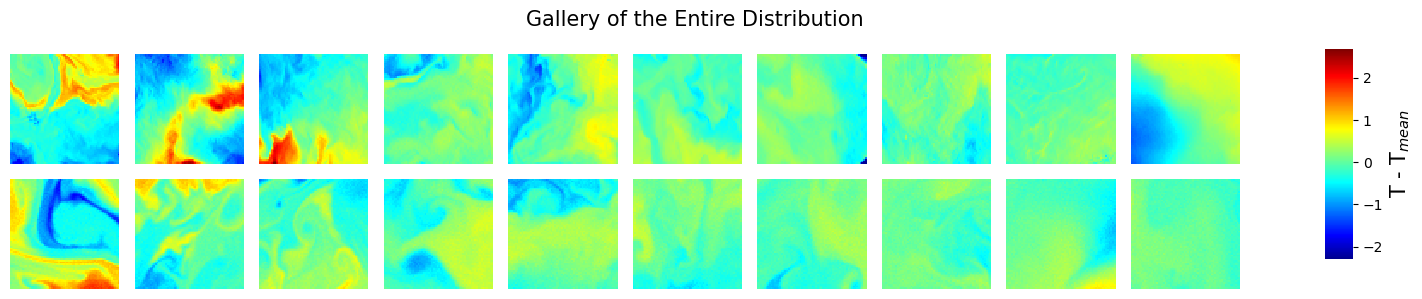

In [28]:
#create figure

fig, axes = plt.subplots(2, 10, figsize = (14,3) )

fig.suptitle( 'Gallery of the Entire Distribution', fontsize=15)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_kws={"orientation": "vertical", "shrink":1, "aspect":40, "label": "T - T$_{mean}$"}
pal, cm = plotting.load_palette()

#determine tmax and tmin
imgs = np.empty((64,64,20))
LLs  = np.empty(20)

for i in range(0,10):
    lidx = limgs[ i ]
    vidx = vimgs[ i ]
    
    lcutout = llc.iloc[ lidx ] 
    vcutout = v98.iloc[ vidx ] 
    
    limg= llc_io.grab_image(lcutout)
    vimg= llc_io.grab_image(vcutout)
    
    imgs[:,:,i] = vimg
    imgs[:,:,10 + i] = limg
    LLs[i] = vcutout.LL
    LLs[10 + i] = lcutout.LL

if tmax==True: 
    tmax = np.max(imgs)

if tmin==True:
    tmin = np.min(imgs)
print('Temperature scale is {} to {}.'.format(tmin, tmax))

# plot

for i, ax in enumerate(axes.flat):
    
    if i in range(0, 20):

       

        img = viirs_imgs[:,:,i]

        sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap='viridis',
                    cbar=i == 0, vmin=tmin, vmax=tmax,
                    cbar_ax=None if i else cbar_ax,
                    cbar_kws=None if i else cbar_kws)

    elif i in range(20, 40):

        img = viirs_imgs[:, :, i]

        ax.contour(img, levels = 10)
    
    ax.set_title('LL = {}'.format(round(LLs[i])))
    ax.figure.axes[-1].yaxis.label.set_size(15)

fig.tight_layout(rect=[0, 0, .9, 1])

plt.savefig('entire_distribution_by_deciles', dpi = 600)

## Pick 4 random cutouts from each decile

In [6]:
# pick 4 cutout from each percentile region
larr = np.empty((10,4))
varr = np.empty((10,4))

for i, reg in enumerate(llc_rs): 
    img = np.random.choice( reg.index.to_numpy(), size = 4)
    larr[i, :] = img
    
for j, reg in enumerate(v98_rs):
    img = np.random.choice( reg.index.to_numpy(), size = 4)
    varr[j, :] = img
    
limgs = list( int(val) for val in larr.T.flatten() )
vimgs = list( int(val) for val in varr.T.flatten() )

## viirs decile gallery

In [27]:
tmax = True
tmin = True

In [28]:
#determine tmax and tmin
viirs_imgs = np.empty((64,64,40))
LLs  = np.empty(40)

for i in range(0,40):
    idx = vimgs[ i ]
    
    cutout = v98.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    viirs_imgs[:,:,i] = img
    LLs[i] = cutout.LL

if tmax==True: 
    tmax = np.max(viirs_imgs)

if tmin==True:
    tmin = np.min(viirs_imgs)
print('Temperature scale is {} to {}.'.format(tmin, tmax))

Temperature scale is -3.6563920974731445 to 3.043031692504883.


/tmp/ipykernel_9803/2443926520.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


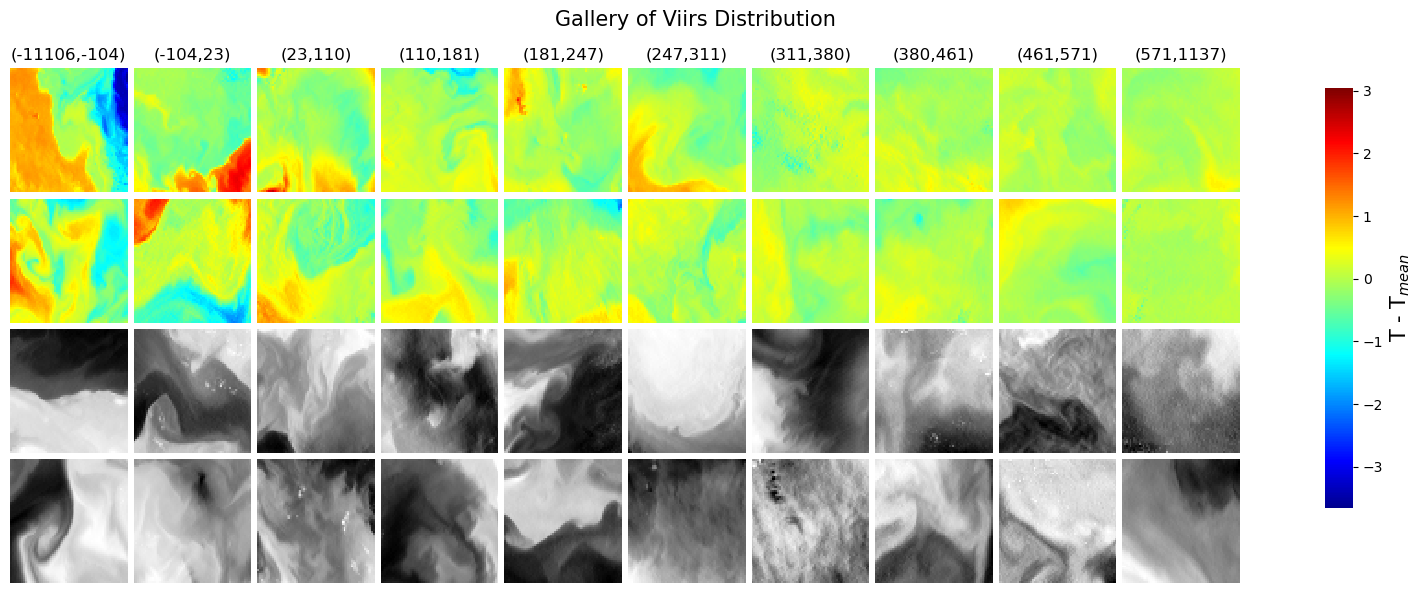

In [30]:
#create figure

fig, axes = plt.subplots(4, 10, figsize = (14,6) )

fig.suptitle( 'Gallery of Viirs Distribution', fontsize=15)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_kws={"orientation": "vertical", "shrink":1, "aspect":40, "label": "T - T$_{mean}$"}
pal, cm = plotting.load_palette()


# plot

for i, ax in enumerate(axes.flat):

    if i in range(0, 20):

        img = viirs_imgs[:,:,i]
        sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0, vmin=tmin, vmax=tmax, cbar_ax=None if i else cbar_ax,
                    cbar_kws=None if i else cbar_kws)

    elif i in range(20, 40):

        img = viirs_imgs[:, :, i]
        #ax.contour(img, levels=3, cmap='Greys')
        sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap='Greys',
                cbar=i == 0, cbar_ax=None if i else cbar_ax,
                    cbar_kws=None if i else cbar_kws)
        
    if i < 10: 
        ax.set_title('({},{})'.format(round(v98_rs[i].LL.min()), round(v98_rs[i].LL.max())))
    #ax.set_title('LL = {}'.format(round(LLs[i])))
    ax.figure.axes[-1].yaxis.label.set_size(15)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('viirs_by_deciles', dpi = 600)
#plt.show()

## llc decile gallery

In [34]:
tmax = True
tmin = True

In [35]:
#determine tmax and tmin
llc_imgs = np.empty((64,64,40))
LLs  = np.empty(40)

for i in range(0,40):
    idx = limgs[ i ]
    
    cutout = llc.iloc[ idx ] 
    
    img= llc_io.grab_image(cutout)
    
    llc_imgs[:,:,i] = img
    LLs[i] = cutout.LL

if tmax==True: 
    tmax = np.max(llc_imgs)

if tmin==True:
    tmin = np.min(llc_imgs)
print('Temperature scale is {} to {}.'.format(tmin, tmax))

Temperature scale is -4.866277694702148 to 2.90962553024292.


/tmp/ipykernel_9803/2354081023.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


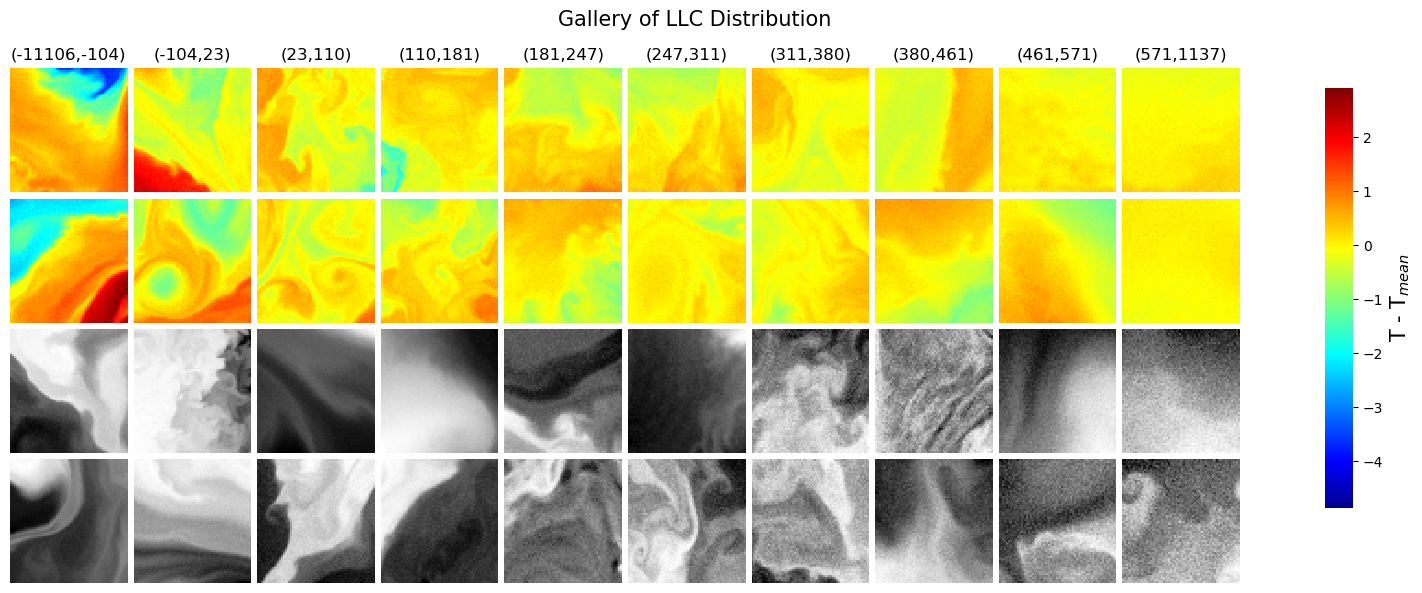

In [36]:
#create figure

fig, axes = plt.subplots(4, 10, figsize = (14,6) )

fig.suptitle( 'Gallery of LLC Distribution', fontsize=15)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar_kws={"orientation": "vertical", "shrink":1, "aspect":40, "label": "T - T$_{mean}$"}
pal, cm = plotting.load_palette()


# plot

for i, ax in enumerate(axes.flat):
    if i in range(0, 20):

        img = llc_imgs[:,:,i]
        sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap=cm,
                cbar=i == 0, vmin=tmin, vmax=tmax, cbar_ax=None if i else cbar_ax,
                    cbar_kws=None if i else cbar_kws)

    elif i in range(20, 40):

        img = llc_imgs[:, :, i]
        #ax.contour(img, levels=3, cmap='Greys')
        sns.heatmap(ax=ax, data=img, xticklabels=[], yticklabels=[], cmap='Greys',
                cbar=i == 0, cbar_ax=None if i else cbar_ax,
                    cbar_kws=None if i else cbar_kws)
        
    if i < 10: 
        ax.set_title('({},{})'.format(round(v98_rs[i].LL.min()), round(v98_rs[i].LL.max())))
    #ax.set_title('LL = {}'.format(round(LLs[i])))
    ax.figure.axes[-1].yaxis.label.set_size(15)

fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('llc_by_deciles', dpi = 600)
#plt.show()